In [1]:
import generate_masterdf as gm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from generate_plots import subject_wise_error_plot, quick_visualization, distribution_plots
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)

We have 4 subjects so far: ['sub01', 'sub03', 'sub06', 'sub15']

Loading existing dataframe! If this is not desired, delete the current mater_df.csv


In [2]:
df = gm.master_df
print('Dataframe description')
df.info()

Dataframe description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subjID                4800 non-null   int64  
 1   day                   4800 non-null   int64  
 2   tnum                  4800 non-null   int64  
 3   rnum                  4800 non-null   int64  
 4   istms                 4800 non-null   int64  
 5   ispro                 4800 non-null   int64  
 6   instimVF              4800 non-null   int64  
 7   breakfix              4800 non-null   int64  
 8   no_prim_sacc          4800 non-null   int64  
 9   small_sacc            4800 non-null   int64  
 10  large_error           4800 non-null   int64  
 11  rejtrials             4800 non-null   int64  
 12  TarX                  4800 non-null   float64
 13  TarY                  4800 non-null   float64
 14  isaccX                4800 non-null   float64
 15 

In [3]:
df.describe()

,subjID,day,tnum,rnum,istms,ispro,instimVF,breakfix,no_prim_sacc,small_sacc,large_error,rejtrials,TarX,TarY,isaccX,isaccY,fsaccX,fsaccY,isacc_err,fsacc_err,isacc_theta_err,fsacc_theta_err,corrected_theta_err,isacc_radius_err,fsacc_radius_err,corrected_radius_err,nsacc,calib_err,isacc_rt,fsacc_rt,isacc_peakvel,fsacc_peakvel
count,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4800.0000,4727.0000,4742.0000,4727.0000,4742.0000,4727.0000,4727.0000,4742.0000,4727.0000,4800.0000,4795.0000,4727.0000,4742.0000,4727.0000,4742.0000
mean,6.2500,2.0000,20.5000,5.5000,0.6667,0.5000,0.5000,0.0394,0.0121,0.0031,0.0160,0.0281,4.0368,-2.2684,4.1947,-3.5499,4.6068,-5.7858,1.9788,1.5389,0.0562,0.0326,-0.0255,-0.1554,-0.1081,0.0645,1.6715,1.1098,0.3049,0.4476,324.9856,200.4225
std,5.3566,0.8166,11.5446,2.8726,0.4715,0.5001,0.5001,0.1945,0.1093,0.0558,0.1256,0.1653,14.1420,2.0803,14.2755,3.2731,14.3956,9.2852,3.2858,3.2150,0.7649,0.7318,0.4212,1.9176,1.4047,1.5873,0.8141,2.8286,0.0838,0.1727,103.6734,145.6533
min,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-17.3950,-4.4038,-18.4887,-7.8345,-17.3365,-35.0947,0.0056,0.0056,-6.2566,-6.2574,-6.2795,-14.0439,-16.9893,-11.5811,0.0000,0.0065,0.0130,0.0470,41.4283,31.4094
25%,2.5000,1.0000,10.7500,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-14.5050,-4.2043,-13.5454,-6.6952,-13.5454,-5.5713,0.7941,0.5769,-0.0258,-0.0234,-0.0097,-1.0719,-0.8231,-0.4728,1.0000,0.3806,0.2520,0.2880,250.5241,73.6712
50%,4.5000,2.0000,20.5000,5.5000,1.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,13.0187,-2.5459,12.1735,-3.9026,12.7812,-3.9420,1.3880,1.0502,0.0083,0.0043,0.0000,0.0122,-0.0425,0.0000,2.0000,0.5990,0.2820,0.4270,307.1162,139.2318
75%,8.2500,3.0000,30.2500,8.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,14.3743,-1.1766,14.3866,-0.8159,15.1286,-1.1051,2.1933,1.6351,0.0445,0.0346,0.0000,0.9950,0.6654,0.0802,2.0000,0.8757,0.3300,0.5797,403.2110,305.3042
max,15.0000,3.0000,40.0000,10.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,15.8537,3.1652,18.7097,3.0808,18.0608,3.0349,38.9050,36.6454,6.2809,6.2793,6.2810,11.6122,22.9536,27.9670,14.0000,35.5759,0.8400,0.8520,599.7850,570.1034


In [4]:
df.describe(include=object)

,trial_type,TMS_condition
count,4800,4800
unique,4,3
top,pro_intoVF,TMS intoVF
freq,1200,1600


In [5]:
n_rows_original = len(df)
# Filter out entries with 'rejtrials' == 1
df_filtered = df[df['rejtrials'] != 1].copy()
df_filtered = df_filtered.dropna()
n_rows_filtered = len(df_filtered)
print(f"Original = {n_rows_original}, after filtering = {n_rows_filtered} trials.")
print()
print('Dataframe description after filtering')
df_filtered.info()

Original = 4800, after filtering = 4649 trials.

Dataframe description after filtering
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4649 entries, 0 to 4798
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subjID                4649 non-null   int64  
 1   day                   4649 non-null   int64  
 2   tnum                  4649 non-null   int64  
 3   rnum                  4649 non-null   int64  
 4   istms                 4649 non-null   int64  
 5   ispro                 4649 non-null   int64  
 6   instimVF              4649 non-null   int64  
 7   breakfix              4649 non-null   int64  
 8   no_prim_sacc          4649 non-null   int64  
 9   small_sacc            4649 non-null   int64  
 10  large_error           4649 non-null   int64  
 11  rejtrials             4649 non-null   int64  
 12  TarX                  4649 non-null   float64
 13  TarY                  4649 non-null 

In [6]:
df_filtered.describe()

,subjID,day,tnum,rnum,istms,ispro,instimVF,breakfix,no_prim_sacc,small_sacc,large_error,rejtrials,TarX,TarY,isaccX,isaccY,fsaccX,fsaccY,isacc_err,fsacc_err,isacc_theta_err,fsacc_theta_err,corrected_theta_err,isacc_radius_err,fsacc_radius_err,corrected_radius_err,nsacc,calib_err,isacc_rt,fsacc_rt,isacc_peakvel,fsacc_peakvel
count,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0,4649.0,4649.0,4649.0,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000,4649.0000
mean,6.1811,2.0043,20.5175,5.4863,0.6621,0.4997,0.4977,0.0364,0.0,0.0,0.0,0.0,3.9376,-2.2537,4.1094,-3.5388,4.4973,-5.6730,1.6152,1.2050,0.0501,0.0272,-0.0230,-0.1085,-0.0870,0.0215,1.6872,0.9168,0.3044,0.4453,326.0321,200.9975
std,5.3469,0.8143,11.5230,2.8783,0.4731,0.5001,0.5000,0.1872,0.0,0.0,0.0,0.0,14.1782,2.0819,14.3237,3.2856,14.4272,9.1466,1.1828,1.0555,0.7151,0.6808,0.4122,1.7152,1.2690,1.3873,0.7922,2.0031,0.0827,0.1716,103.2173,146.2364
min,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,-17.3950,-4.4038,-18.4887,-7.8345,-17.3365,-35.0947,0.0056,0.0056,-6.2566,-6.2574,-6.2795,-9.5277,-12.6825,-11.5811,1.0000,0.0065,0.0130,0.0700,51.3152,31.4094
25%,1.0000,1.0000,11.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,-15.0005,-4.1836,-14.4749,-7.0161,-14.4749,-5.0897,0.7822,0.5701,-0.0255,-0.0233,-0.0092,-1.0497,-0.8174,-0.4776,1.0000,0.3782,0.2520,0.2870,251.6024,73.7120
50%,3.0000,2.0000,21.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,13.1288,-2.4771,13.0797,-3.5027,12.5236,-3.5027,1.3639,1.0387,0.0078,0.0039,0.0000,0.0141,-0.0431,0.0000,2.0000,0.5922,0.2810,0.4250,307.6615,139.6230
75%,6.0000,3.0000,30.0000,8.0000,1.0000,1.0000,1.0000,0.0000,0.0,0.0,0.0,0.0,14.2023,-0.9909,14.6117,-0.6203,14.6117,-0.6947,2.1359,1.6081,0.0431,0.0337,0.0000,0.9944,0.6645,0.0552,2.0000,0.8630,0.3300,0.5770,405.9109,306.7642
max,15.0000,3.0000,40.0000,10.0000,1.0000,1.0000,1.0000,1.0000,0.0,0.0,0.0,0.0,15.8537,3.1652,18.7097,3.0808,18.0608,3.0349,9.8968,30.9722,6.2809,6.2793,6.2810,5.8817,22.9536,27.9670,14.0000,18.1298,0.8400,0.8520,588.4051,570.1034


In [7]:
df_filtered.describe(include=object)

,trial_type,TMS_condition
count,4649,4649
unique,4,3
top,pro_outVF,No TMS
freq,1168,1571


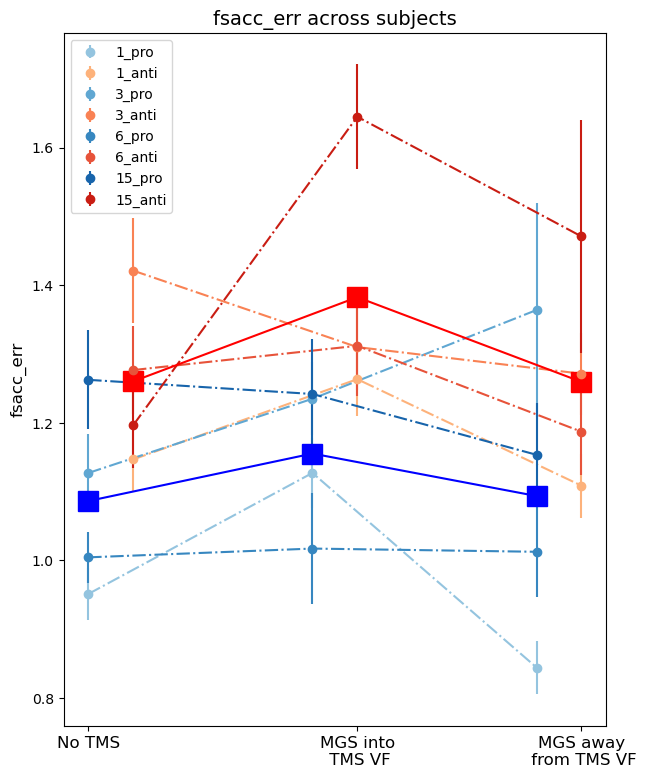

In [8]:
subject_wise_error_plot(df_filtered, 'fsacc_err')

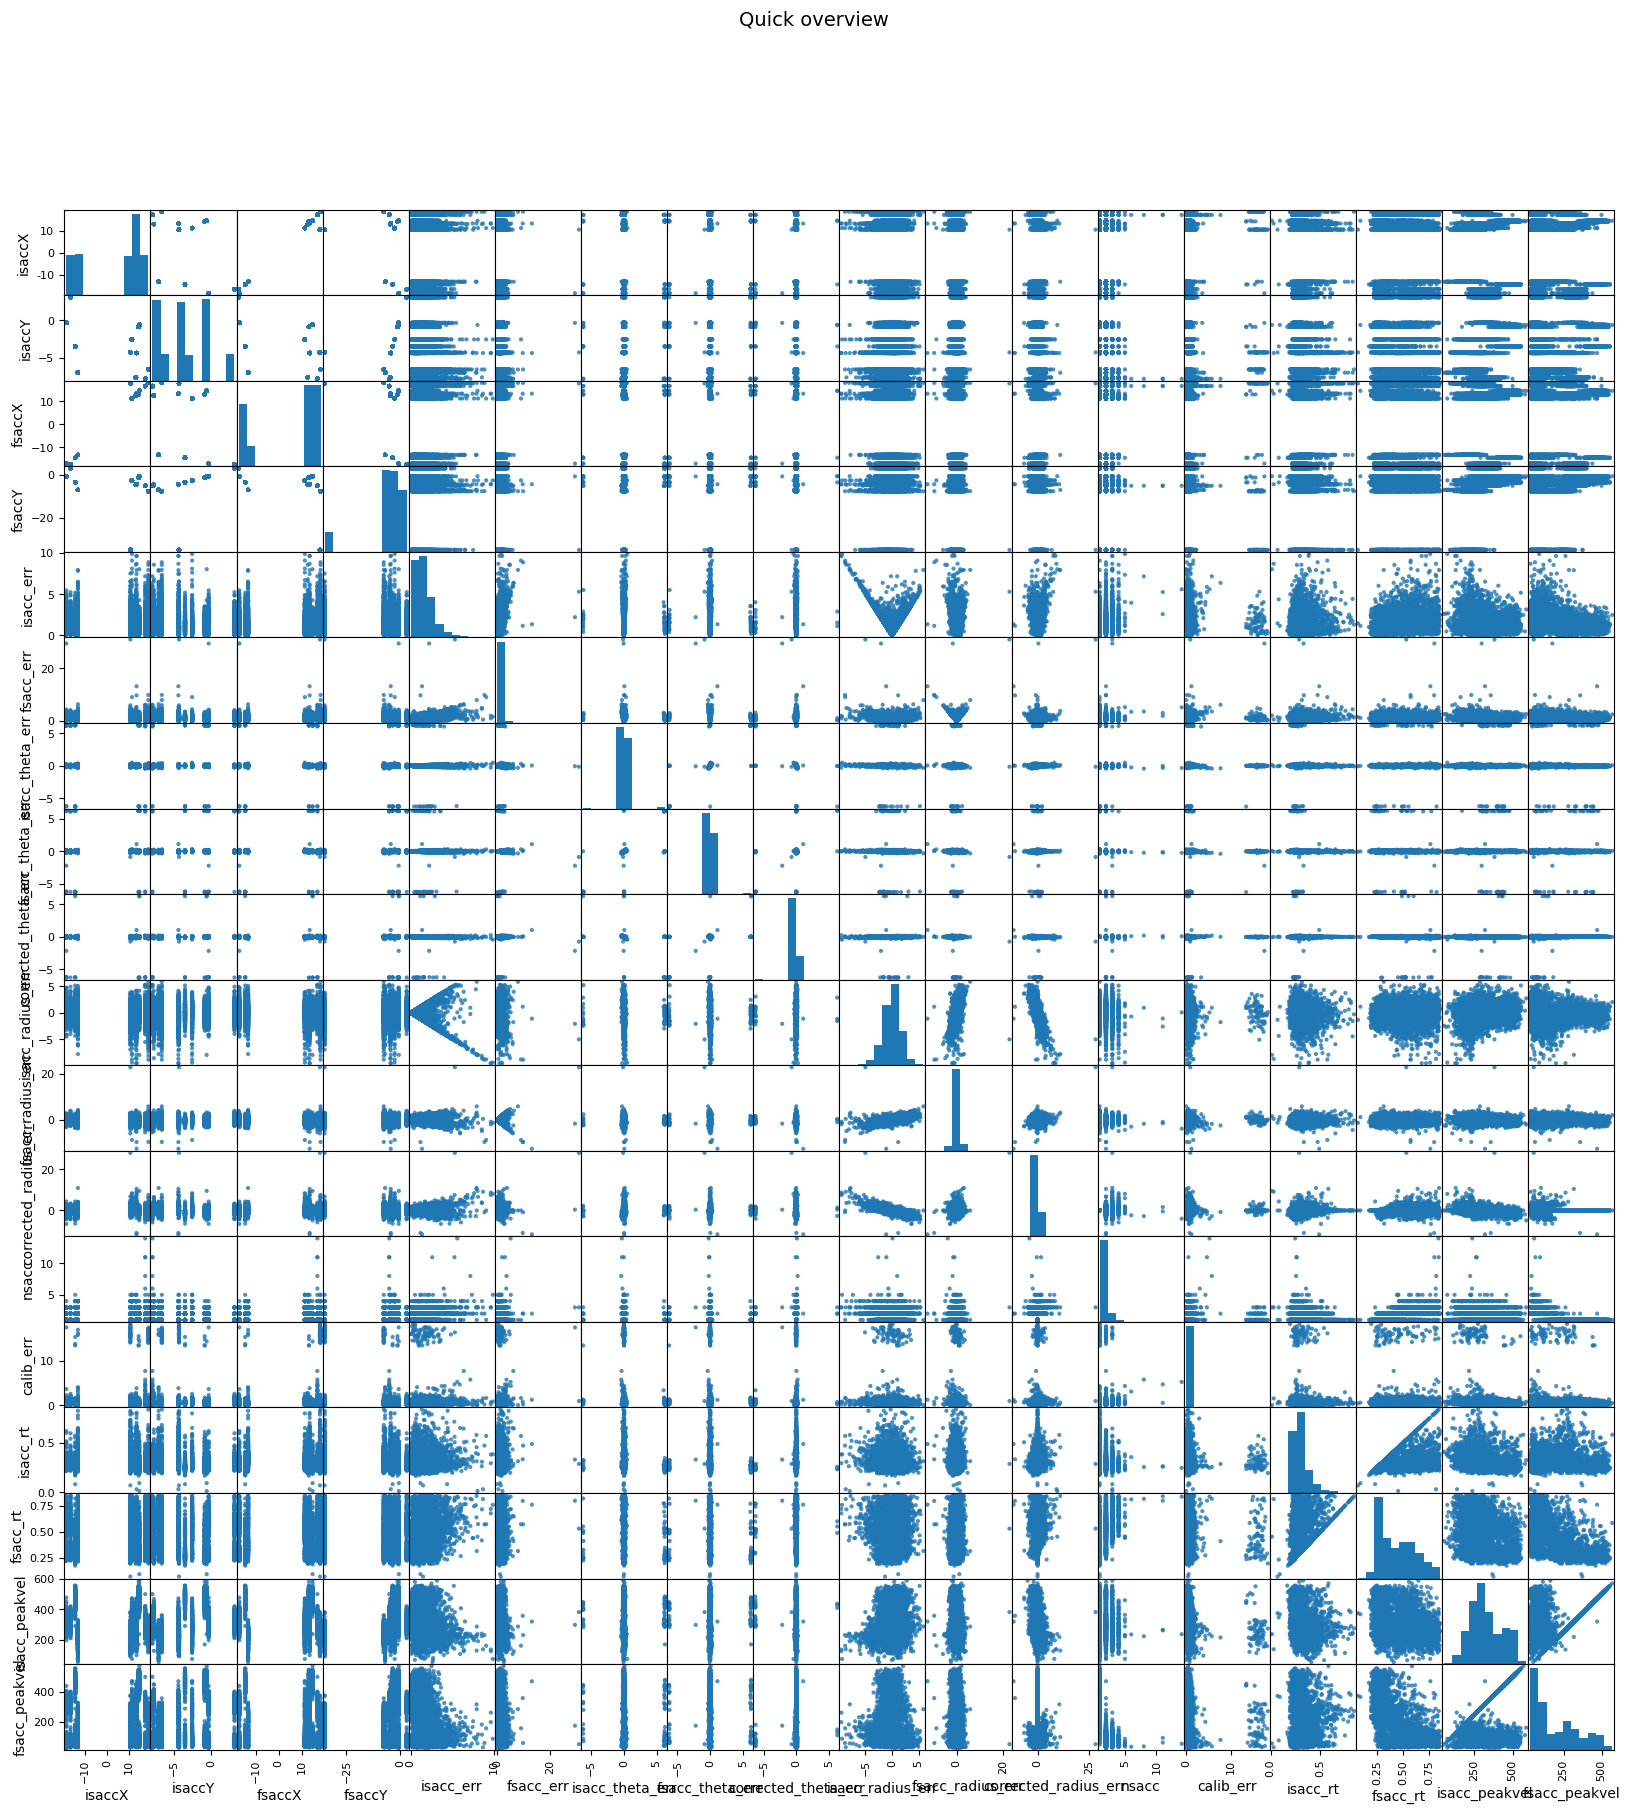

In [9]:
quick_visualization(df_filtered)

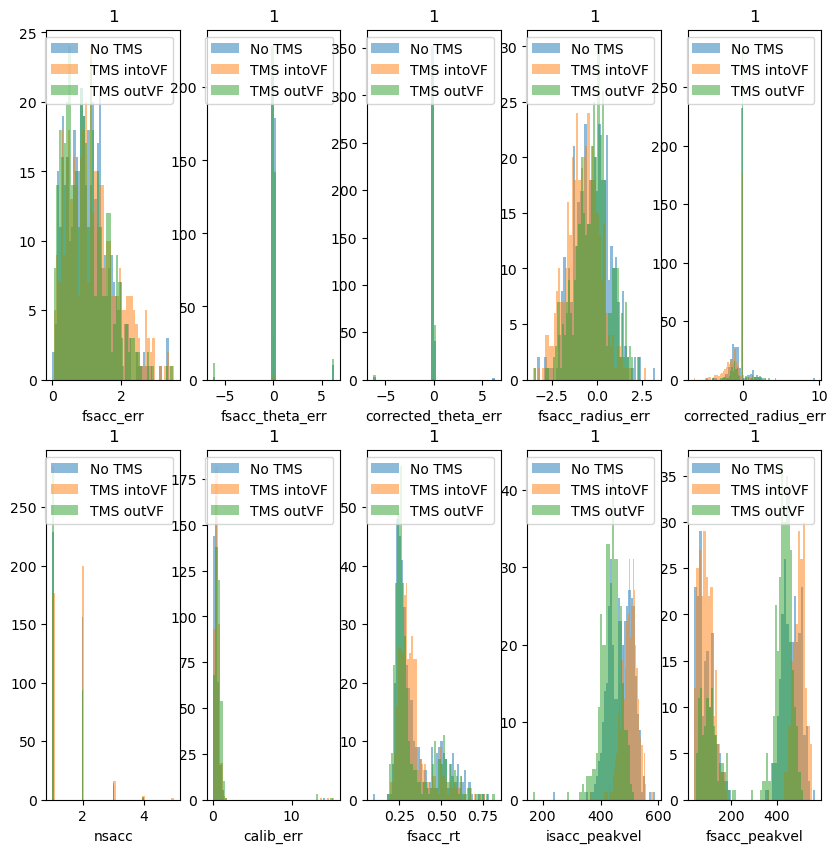

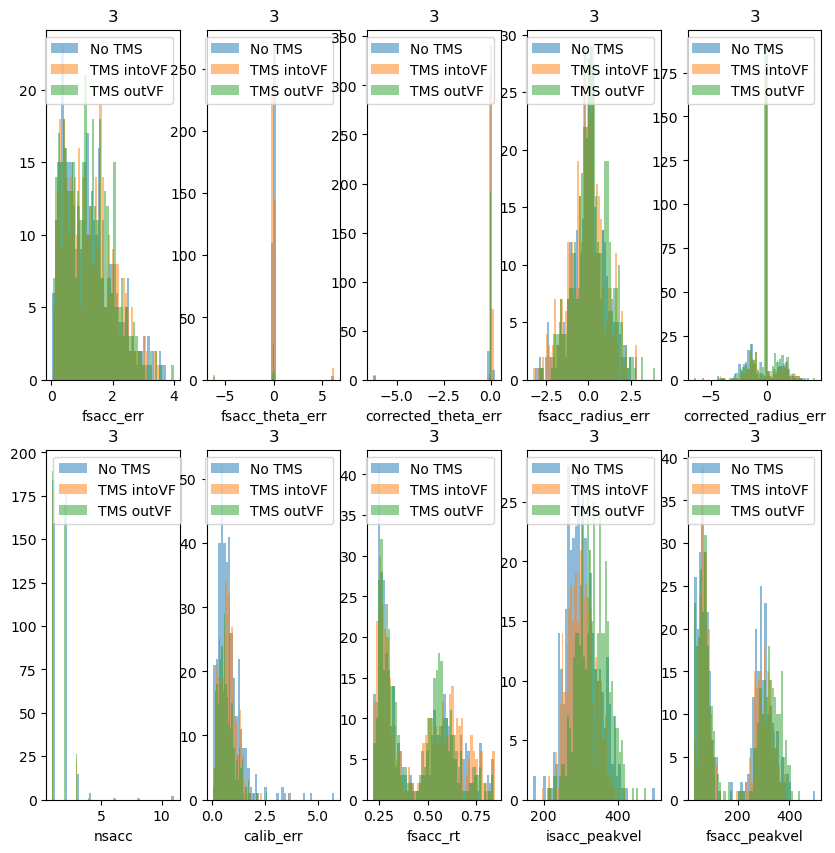

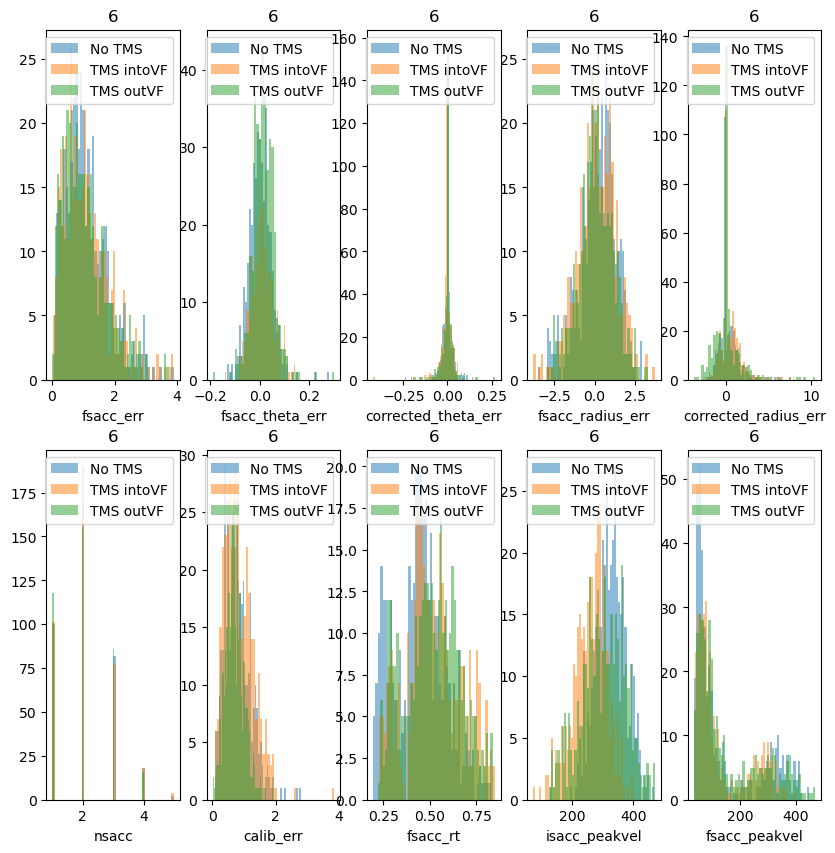

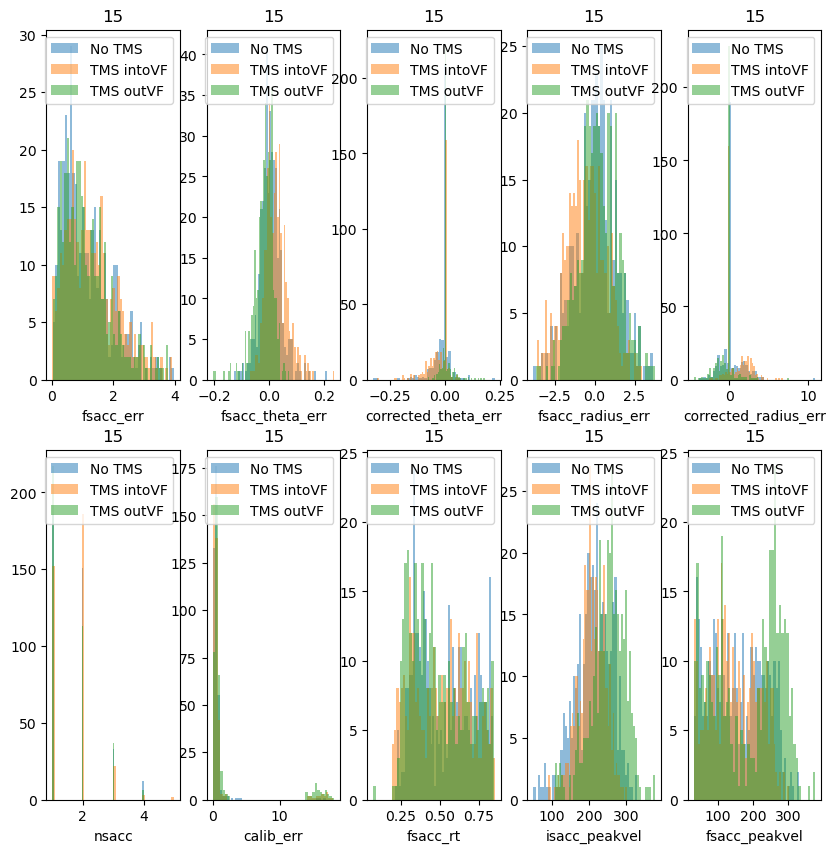

In [10]:
distribution_plots(df_filtered)